In [7]:
%run './model/multi_corpus.py'
%run './constants.py'

from matplotlib import cm

In [5]:
corpora = citation_graphs()
Gs = {field_name: corpus['G'] for (field_name, corpus) in corpora.items()}
Dfs = {field_name: corpus['Df'] for (field_name, corpus) in corpora.items()}

Gender Studies DiGraph with 4498 nodes and 10516 edges
Geometry DiGraph with 5513 nodes and 7766 edges
Geophysics DiGraph with 51481 nodes and 222792 edges
Economics DiGraph with 9092 nodes and 77939 edges
Language & Linguistics DiGraph with 4352 nodes and 21175 edges
Probability & Statistics DiGraph with 8228 nodes and 29299 edges
Material Engineering DiGraph with 59034 nodes and 447905 edges
Artificial Intelligence DiGraph with 8066 nodes and 33053 edges
Sociology DiGraph with 5308 nodes and 35343 edges
International Business DiGraph with 7934 nodes and 61098 edges
Political Science DiGraph with 7300 nodes and 38877 edges
Genetics & Genomics DiGraph with 33382 nodes and 140529 edges
Immunology DiGraph with 42506 nodes and 290160 edges
Human Resources & Organizations DiGraph with 7825 nodes and 54232 edges
Ethnic & Cultural Studies DiGraph with 3922 nodes and 8950 edges
Neurology DiGraph with 38498 nodes and 343411 edges


# Citation Graphs

In [8]:
cmap = cm.plasma
node_factor = 500
n_cols = 2
n_rows = np.ceil(len(corpora) / n_cols)

sns.set()

fig, axs = plt.subplots(int(n_rows), int(n_cols), figsize=(n_cols*10, n_rows*10))
for (field_name, G), ax in zip(Gs.items(), axs.flatten()):

    print(field_name)

    G = G.to_undirected()
    G = G.subgraph(max(nx.connected_components(G), key=len))
    cent_map = dict(nx.betweenness_centrality(G))

    sorted_cent_map = dict(sorted(cent_map.items(), key=lambda tup: tup[1]))
    node_list = list(sorted_cent_map.keys())
    node_cent = np.fromiter(sorted_cent_map.values(), float)
    normalized_node_map = dict(zip(node_list, node_cent / node_cent.max()))
    normalized_node_list = list(normalized_node_map.keys())
    normalized_node_cent = np.fromiter(normalized_node_map.values(), float)

    pos = nx.nx_agraph.graphviz_layout(G, prog="sfdp") # dot, twopi, fdp, sfdp, circo

    for i, (node, cent) in enumerate(normalized_node_map.items()):
        greater_nodes = nx.draw_networkx_nodes(
            G, 
            pos, 
            nodelist=[node],
            node_size=[cent * node_factor],
            # node_color=[cent],
            node_shape='o',
            alpha=1,
            ax=ax,
            cmap=cmap,
            linewidths=1,
            edgecolors='k',
            margins=None,
        )
        greater_nodes.set_zorder(i)

    edges = nx.draw_networkx_edges(
        G, 
        pos,
        width=1.0,
        edge_color='k',
        style='solid',
        alpha=0.1,
        ax=ax,
        arrows=True,
        nodelist=node_list,
        node_size=node_cent * node_factor,
        node_shape='o',
        connectionstyle='arc3, rad=0.3',
    )

    # edges.set_zorder(-1)
    for c in edges:
        c.set_zorder(-1)

    ax.spines['top'].set_color('k')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['right'].set_color('k')
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1)

    ax.grid(False)

    ax.set_title(f'{field_name.capitalize()}', fontweight='semibold', fontsize=20)
    ax.grid(False)

fig.tight_layout()
plt.savefig(os.path.join(OBSIDIAN_IMG_PATH, 'full_fields.png'))
plt.show()

# 2 m

Gender Studies
Geometry
Geophysics


# Descriptive Citation

In [5]:
d = {}

for field_name, corpus in corpora.items():

    print(field_name)

    G = corpus['G']
    df = corpus['Df']

    nodes = list(G.nodes)

    G_u = G.to_undirected()

    # NODES EDGES
    number_of_nodes = nx.number_of_nodes(G)
    number_of_edges = nx.number_of_edges(G)

    # DENSITY
    density = nx.density(G)

    # TRIANGLES
    triangles = sum(nx.triangles(G.to_undirected()).values()) / 3

    # DEGREE
    in_degree = dict(G.in_degree()).values()
    out_degree = dict(G.out_degree()).values()
    degree = dict(G.degree()).values()
    avg_in_degree = sum(in_degree) / len(in_degree)
    avg_out_degree = sum(out_degree) / len(out_degree)
    avg_degree = sum(degree) / len(degree)

    # GINI
    degrees = G.degree()
    sum_degrees = len(G.edges())
    gini = 1 - sum((degrees[n] / sum_degrees)**2 for n in G.nodes())

    # COMPONENTS
    n_strongly_connected_components = len(list(nx.strongly_connected_components(G)))
    n_weakly_connected_components = len(list(nx.weakly_connected_components(G)))

    # DAG Logest Path
    is_dag = nx.is_directed_acyclic_graph(G)
    dag_longest_path = len(nx.dag_longest_path(G))

    # FLOW HIERARCHY
    # flow_hierarchy = nx.flow_hierarchy(G)

    # DIAMETER
    # diameter = nx.diameter(G_u)

    # AVG SHORTEST PATH
    # average_shortest_path_length = nx.average_shortest_path_length(G_u)

    # TRIADIC CENSUS
    # triadic_census = nx.triadic_census(G)

    # TRANSITIVE CLOSURE
    transitive_closure = nx.transitive_closure(G)
    transitive_closure_dag = nx.transitive_closure_dag(G)

    # NUMBER OF ROOTS
    num_roots = len([n for n in G.nodes() if G.out_degree(n) == 0])
    
    # SHORTEST PATH
    shortest_path = nx.shortest_path_length(G)

    # CLUSTERING
    directed_clustering = nx.average_clustering(G)
    undirected_clustering = nx.average_clustering(G.to_undirected())
    transitivity = nx.transitivity(G)

    # DATES
    start_date, end_date = (
        df
        .filter(pl.col('Doi').is_in(nodes))
        .select(
            pl.col('Date').min().alias('Min'),
            pl.col('Date').max().alias('Max'),
        )
        .row(0)
    )

    # CENTRALIZATION
    indegrees = dict(G.in_degree()).values()
    centralization = float((len(G) * max(indegrees) - sum(indegrees))) / (len(G)-1)**2

    # COMMUNITIES
    louvain_communities = len(nx_comm.louvain_communities(G))
    label_propagation_communities = len(nx_comm.label_propagation_communities(G_u))

    # ISOLATES LOOPS CYCLES
    isolates = nx.number_of_isolates(G)
    loops = nx.number_of_selfloops(G)
    cycles = len(list(nx.simple_cycles(G)))

    d[field_name] = {
        'Nodes': number_of_nodes,
        'Edges': number_of_edges,
        'Density': round(density, 4),
        # 'Diameter': diameter,
        # 'Avg Shortest Path': average_shortest_path_length,
        'Triangles': triangles,
        'AvgIndegree': round(avg_in_degree, 4),
        'AvgOutdegree': round(avg_out_degree, 4),
        'AvgDegree': round(avg_degree, 4),
        'Gini': round(gini, 4),
        'Is DAG': is_dag,
        'DAG Longest Path': dag_longest_path,
        'Number of Roots': num_roots,
        # 'louvain_communities': louvain_communities,
        # 'label_propagation_communities': label_propagation_communities,
        # 'Flow Hierarchy': flow_hierarchy,
        # 'Triadic Census': triadic_census,
        # 'transitive_closure': transitive_closure,
        # 'transitive_closure_dag': transitive_closure_dag,
        'StrongComponent': n_strongly_connected_components,
        'WeakComponent': n_weakly_connected_components,
        'ClusteringDirected': round(directed_clustering, 4),
        'ClusteringUndirected': round(undirected_clustering, 4),
        'Transitivity': round(transitivity, 4),
        'StartDate': start_date,
        'EndDate': end_date,
        'Centralization': round(centralization, 4),
        'Isolates': isolates,
        'Loops': loops,
        'Cycles': cycles,
    }

ds = [{'Field': field_name} | desc_d for field_name, desc_d in d.items()]
df = pl.DataFrame(ds)

df.write_csv(os.path.join(OBSIDIAN_TABLE_PATH, 'citation_descriptive_statistics.csv'))
for c in df.columns:
    print(f'{c},')
df

Gender Studies
Geometry
Geophysics
Economics
Language & Linguistics
Probability & Statistics
Material Engineering


KeyboardInterrupt: 

# Degree Distribution

/var/folders/rz/n4jmlyh1355cy_wkn5gd00x40000gn/T/ipykernel_14218/1662480094.py:17: RuntimeWarning: divide by zero encountered in log
  log_k, log_freq = np.log(k), np.log(freq)


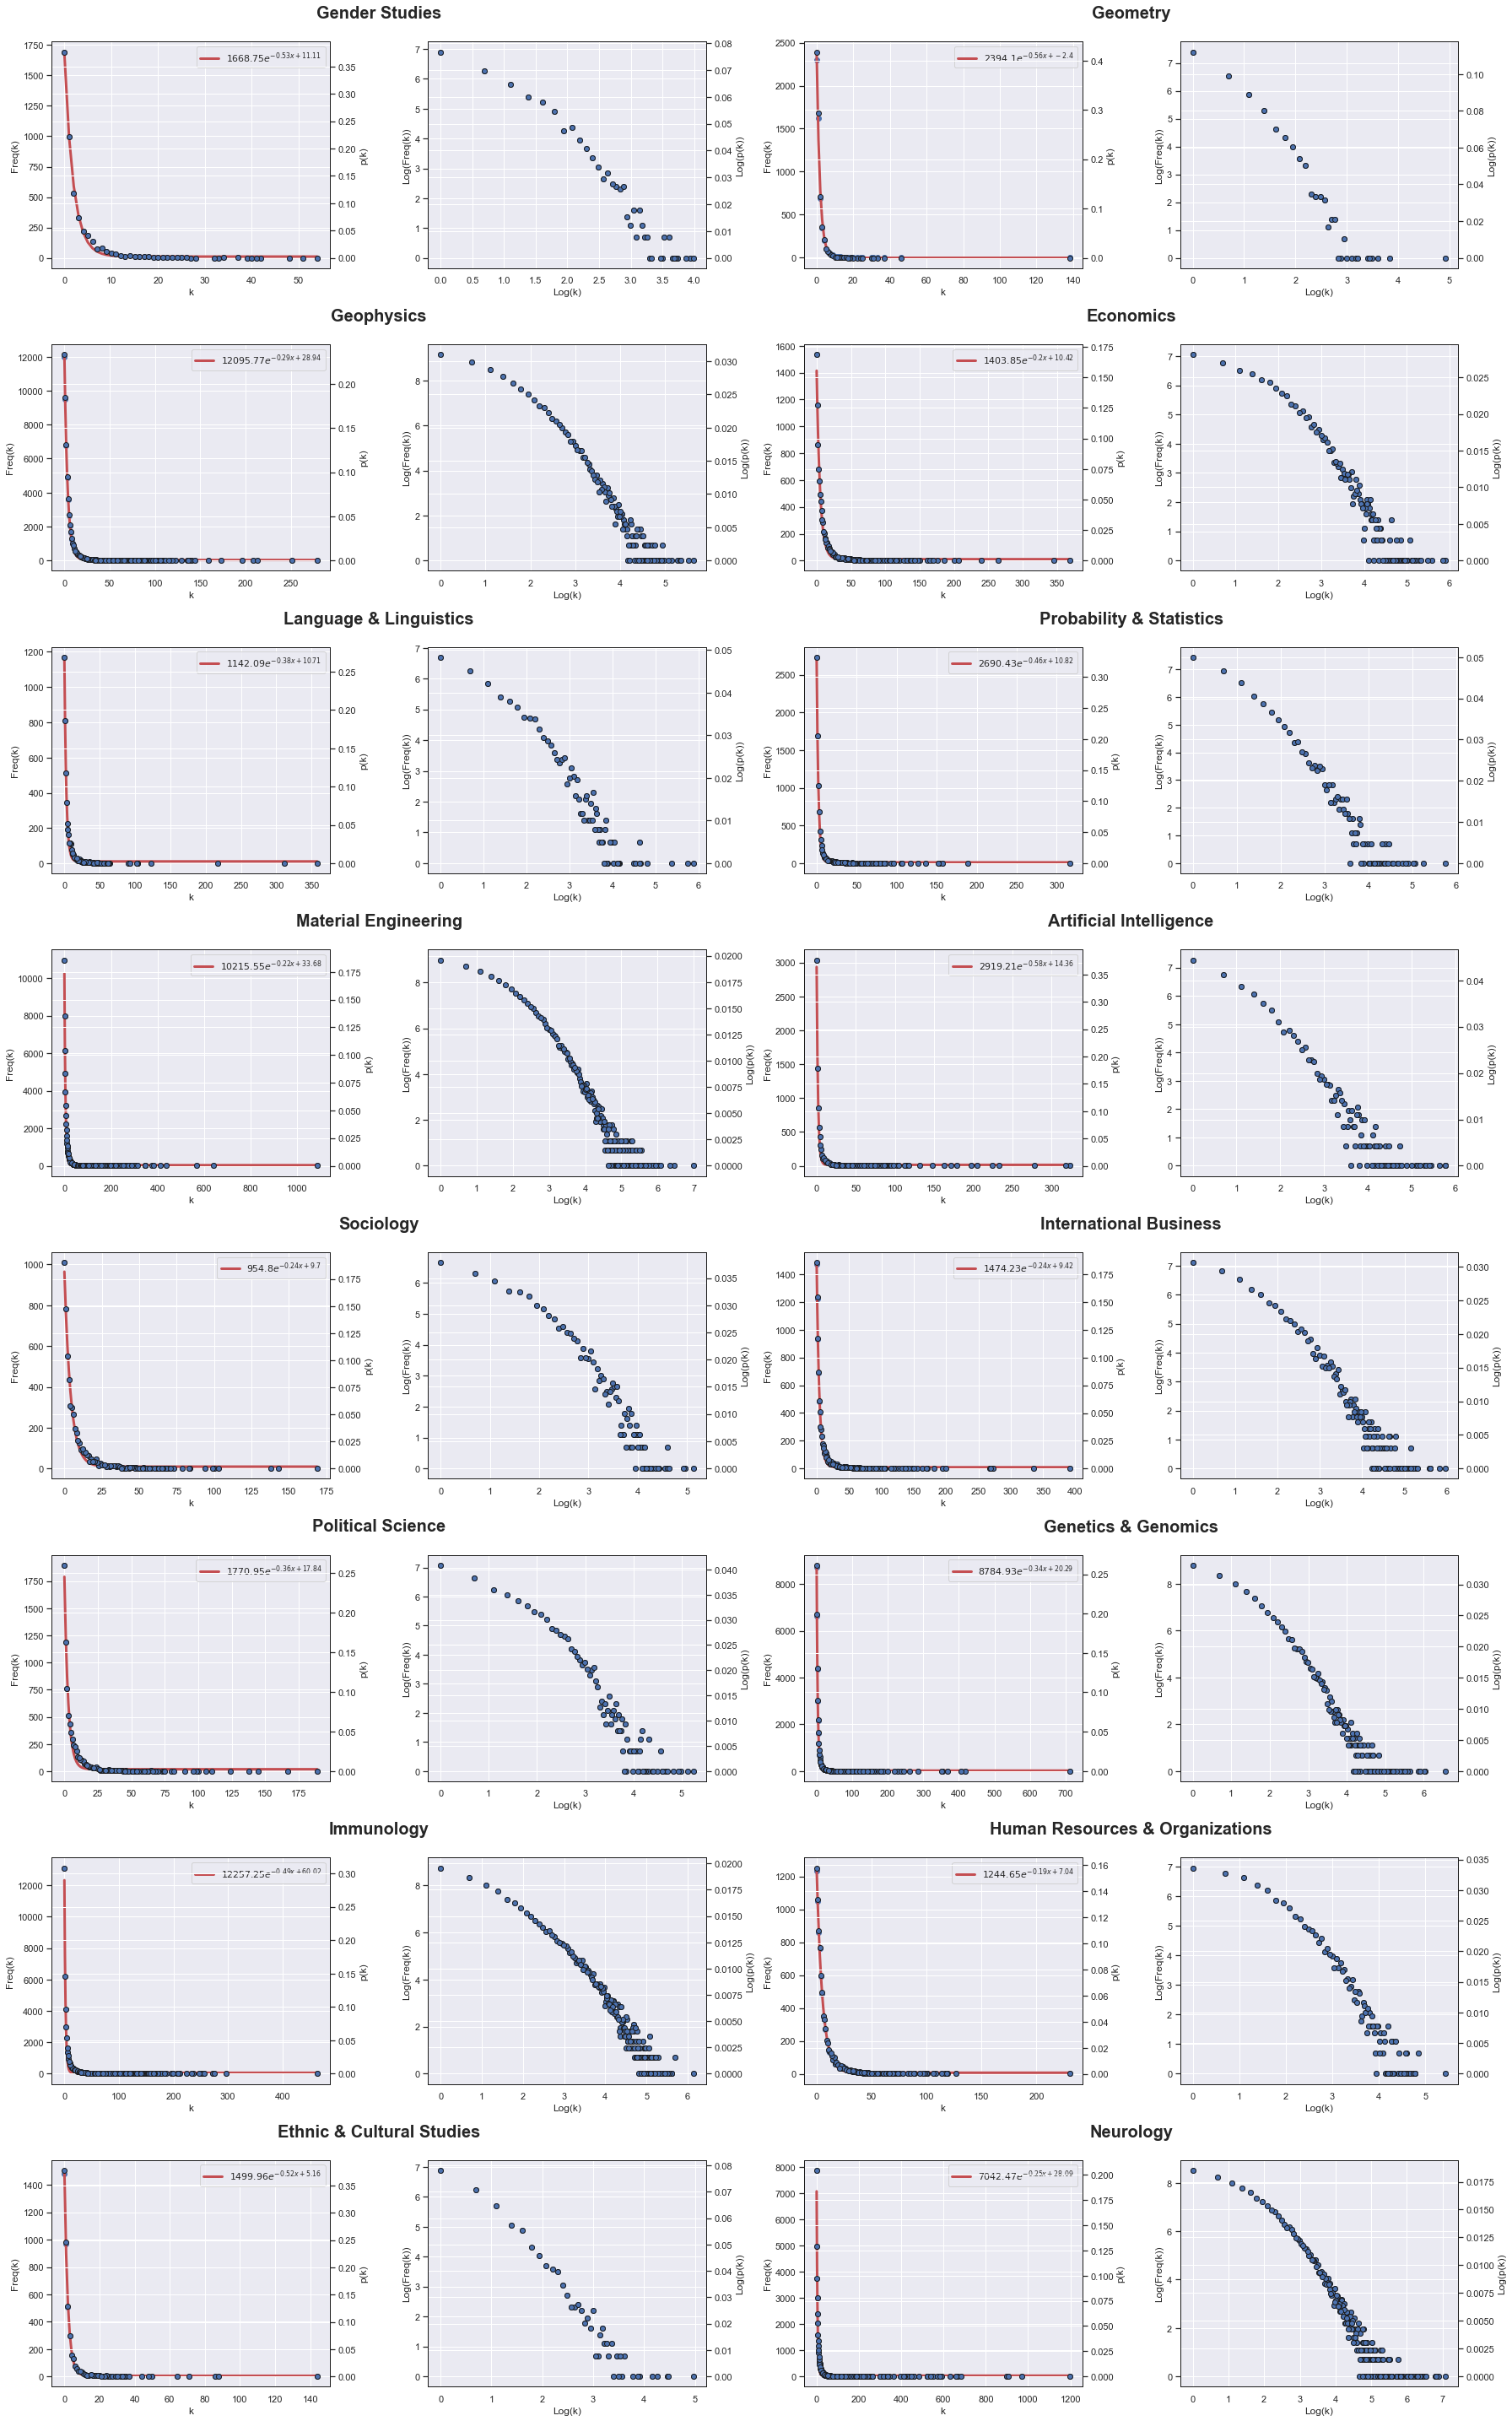

In [7]:

data = []
field_names = []

for i, (field_name, corpus) in enumerate(corpora.items()):

    G = corpus['G']

    if G.is_directed():
        node_degrees = dict(G.in_degree())
    else:
        node_degrees = dict(G.degree())
    degrees = node_degrees.values()

    k, freq = zip(*Counter(degrees).items())
    p_k = np.array(freq) / np.sum(freq)

    log_k, log_freq = np.log(k), np.log(freq)
    log_p_k = np.array(log_freq) / np.sum(log_freq)

    data.append((k, freq, p_k))
    data.append((log_k, log_freq, log_p_k))
    field_names.append(field_name)

data = [data[i:i+4] for i in range(0, len(data), 4)]
field_names = [field_names[i:i+2] for i in range(0, len(field_names), 2)]

n_fields = len([f for field in field_names for f in field])
n_cols = 4
n_rows = int((n_fields+1 if n_fields%2 != 0 else n_fields) / 2)

fig = plt.figure(figsize=(25, n_rows*5))
gs = gridspec.GridSpec(n_rows, n_cols)

for i in range(n_rows):

    row = fig.add_subplot(gs[i, 0:2])
    row.set_frame_on(False)
    row.axis('off')
    try:
        row.set_title(f'{field_names[i][0]}\n', fontweight='semibold', fontsize=20)
    except IndexError:
        pass
    
    row = fig.add_subplot(gs[i, 2:5])
    row.set_frame_on(False)
    row.axis('off')
    try:
        row.set_title(f'{field_names[i][1]}\n', fontweight='semibold', fontsize=20)
    except IndexError:
        pass

    for j in range(n_cols):
        try:
            x, y, p_x = data[i][j]
            ax = fig.add_subplot(gs[i, j])
        except IndexError:
            continue
        
        ax.plot(x, y, 'o')

        axs0 = ax.twinx()
        axs0.plot(x, p_x, 'o', markeredgewidth=1, markeredgecolor='k')

        if j%2 == 0:

            p0 = (1, 0, 0)
            def exponenial_func(x, a, b, c):
                return a*np.exp(-b*x)+c
            popt, pcov = curve_fit(exponenial_func, x, y, p0=p0)
            x_fit = np.arange(0, max(x)+1, 1)
            y_fit = exponenial_func(x_fit, *popt)

            a, b, c = popt.round(2)
            ax.plot(x_fit, y_fit, 'r-', linewidth=3, label=f'${a}e^{{-{b}x + {c}}}$')

            ax.set_xlabel('k')
            ax.set_ylabel('Freq(k)')

            axs0.set_ylabel('p(k)')

            ax.legend()
        else:
            ax.set_xlabel('Log(k)')
            ax.set_ylabel('Log(Freq(k))')

            axs0.set_ylabel('Log(p(k))')

        ax.spines['top'].set_color('k')
        ax.spines['top'].set_linewidth(1)
        ax.spines['bottom'].set_color('k')
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['right'].set_color('k')
        ax.spines['right'].set_linewidth(1)
        ax.spines['left'].set_color('k')
        ax.spines['left'].set_linewidth(1)
        
        axs0.spines['top'].set_color('k')
        axs0.spines['top'].set_linewidth(1)
        axs0.spines['bottom'].set_color('k')
        axs0.spines['bottom'].set_linewidth(1)
        axs0.spines['right'].set_color('k')
        axs0.spines['right'].set_linewidth(1)
        axs0.spines['left'].set_color('k')
        axs0.spines['left'].set_linewidth(1)

plt.tight_layout()

plt.savefig(f'{OBSIDIAN_IMG_PATH}/citation_in_degree_distribution.png')
plt.show()

# Journal

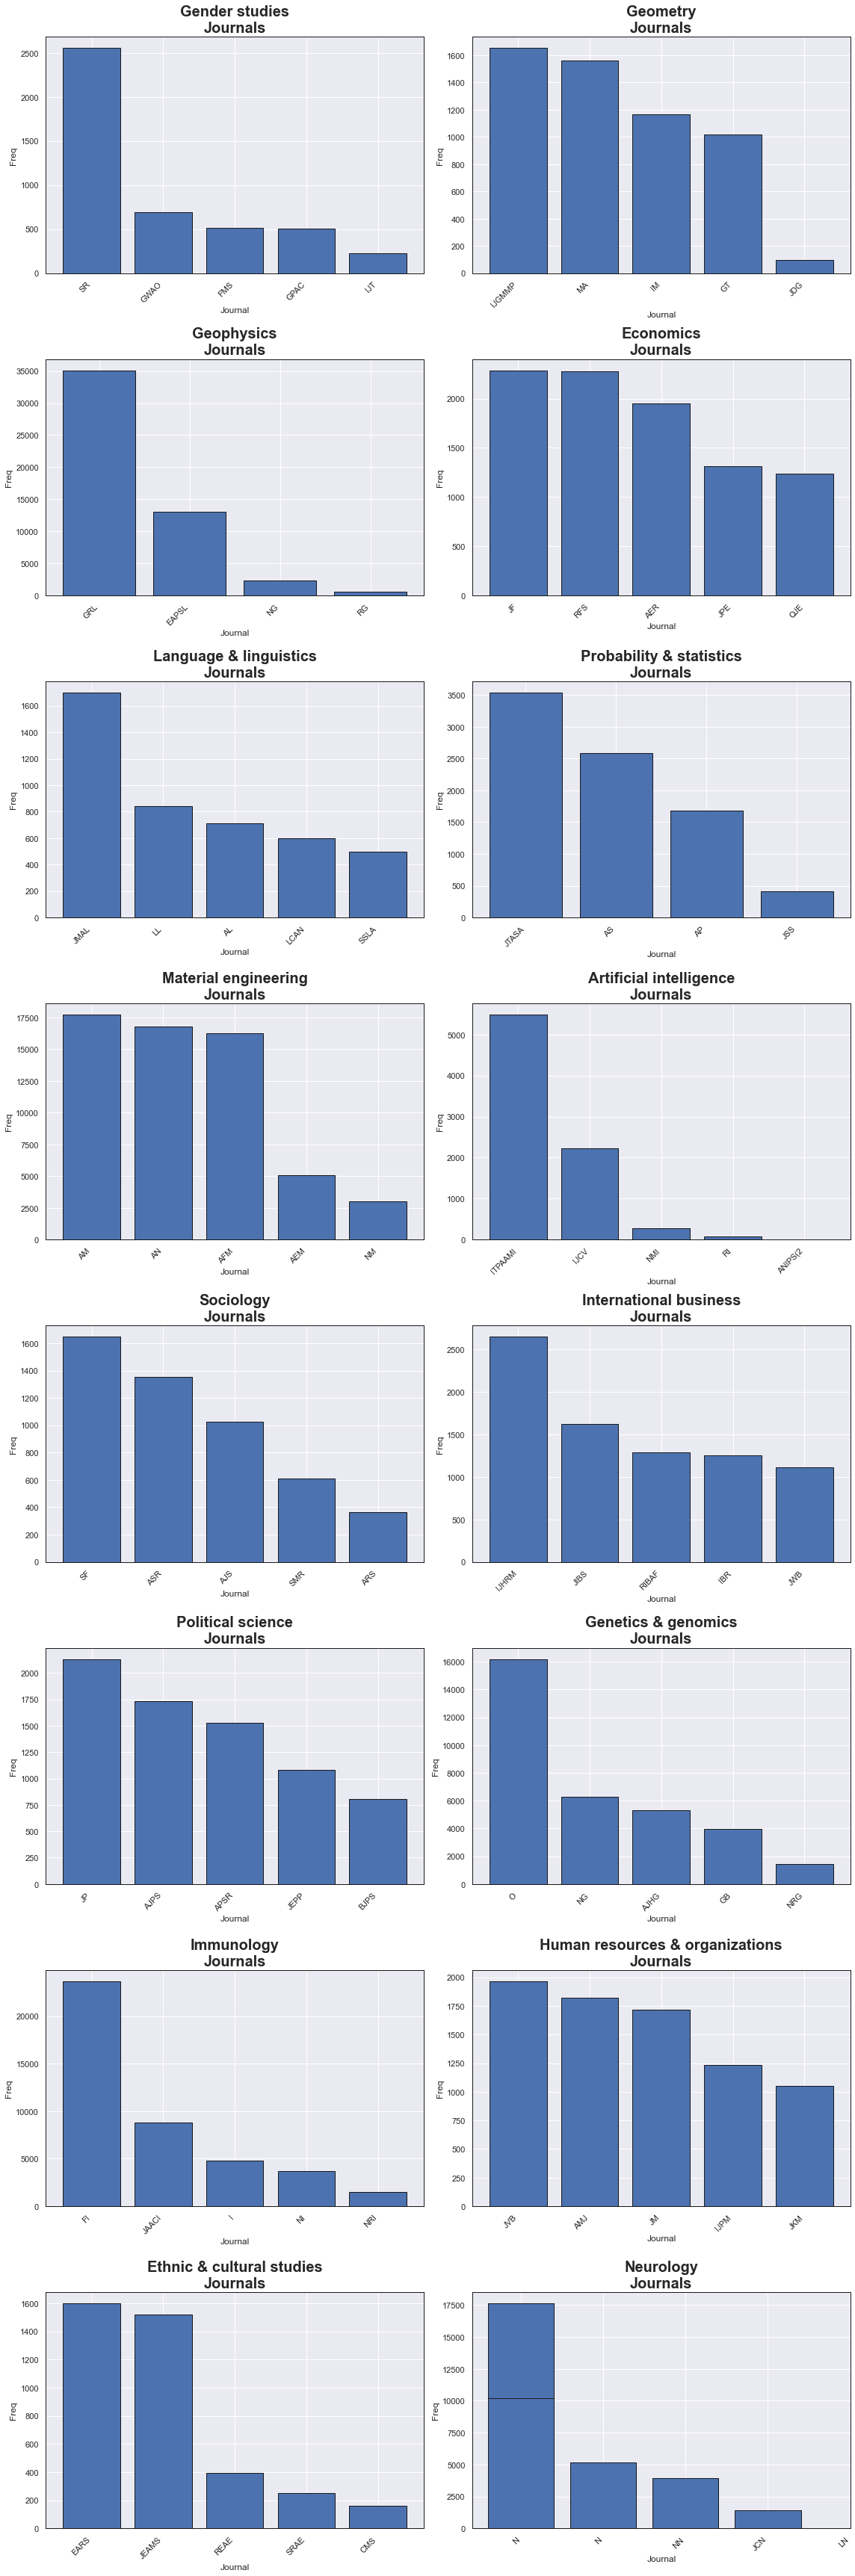

In [8]:
n_cols = 2
height = 6
width = 8
n_rows = np.ceil(len(corpora) / n_cols)

fig, axs = plt.subplots(int(n_rows), int(n_cols), figsize=(n_cols*width, n_rows*height))
for ax, (field_name, corpus) in zip(axs.flatten(), corpora.items()):

    journals, counts = corpus['Df'].groupby('Journal').agg([pl.count()]).sort(pl.col('count'), descending=True)
    journals = journals.to_list()[:5]
    journals = [''.join([word[0].capitalize() for word in journal.split(' ') if len(word) > 2]) for journal in journals]

    counts = counts.to_list()[:5]

    ax.bar(journals, counts, edgecolor='k')
    ax.set_xlabel('Journal')
    ax.set_ylabel('Freq')

    ax.set_xticks(range(len(journals)), journals, rotation=45, ha='right')


    ax.set_title(f'{field_name.capitalize()}\nJournals', fontweight='semibold', fontsize=20)

    ax.spines['top'].set_color('k')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['right'].set_color('k')
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1)

fig.set_facecolor('w')
plt.tight_layout()
plt.savefig(f'{OBSIDIAN_IMG_PATH}/journals.png')
plt.show()

# Categories

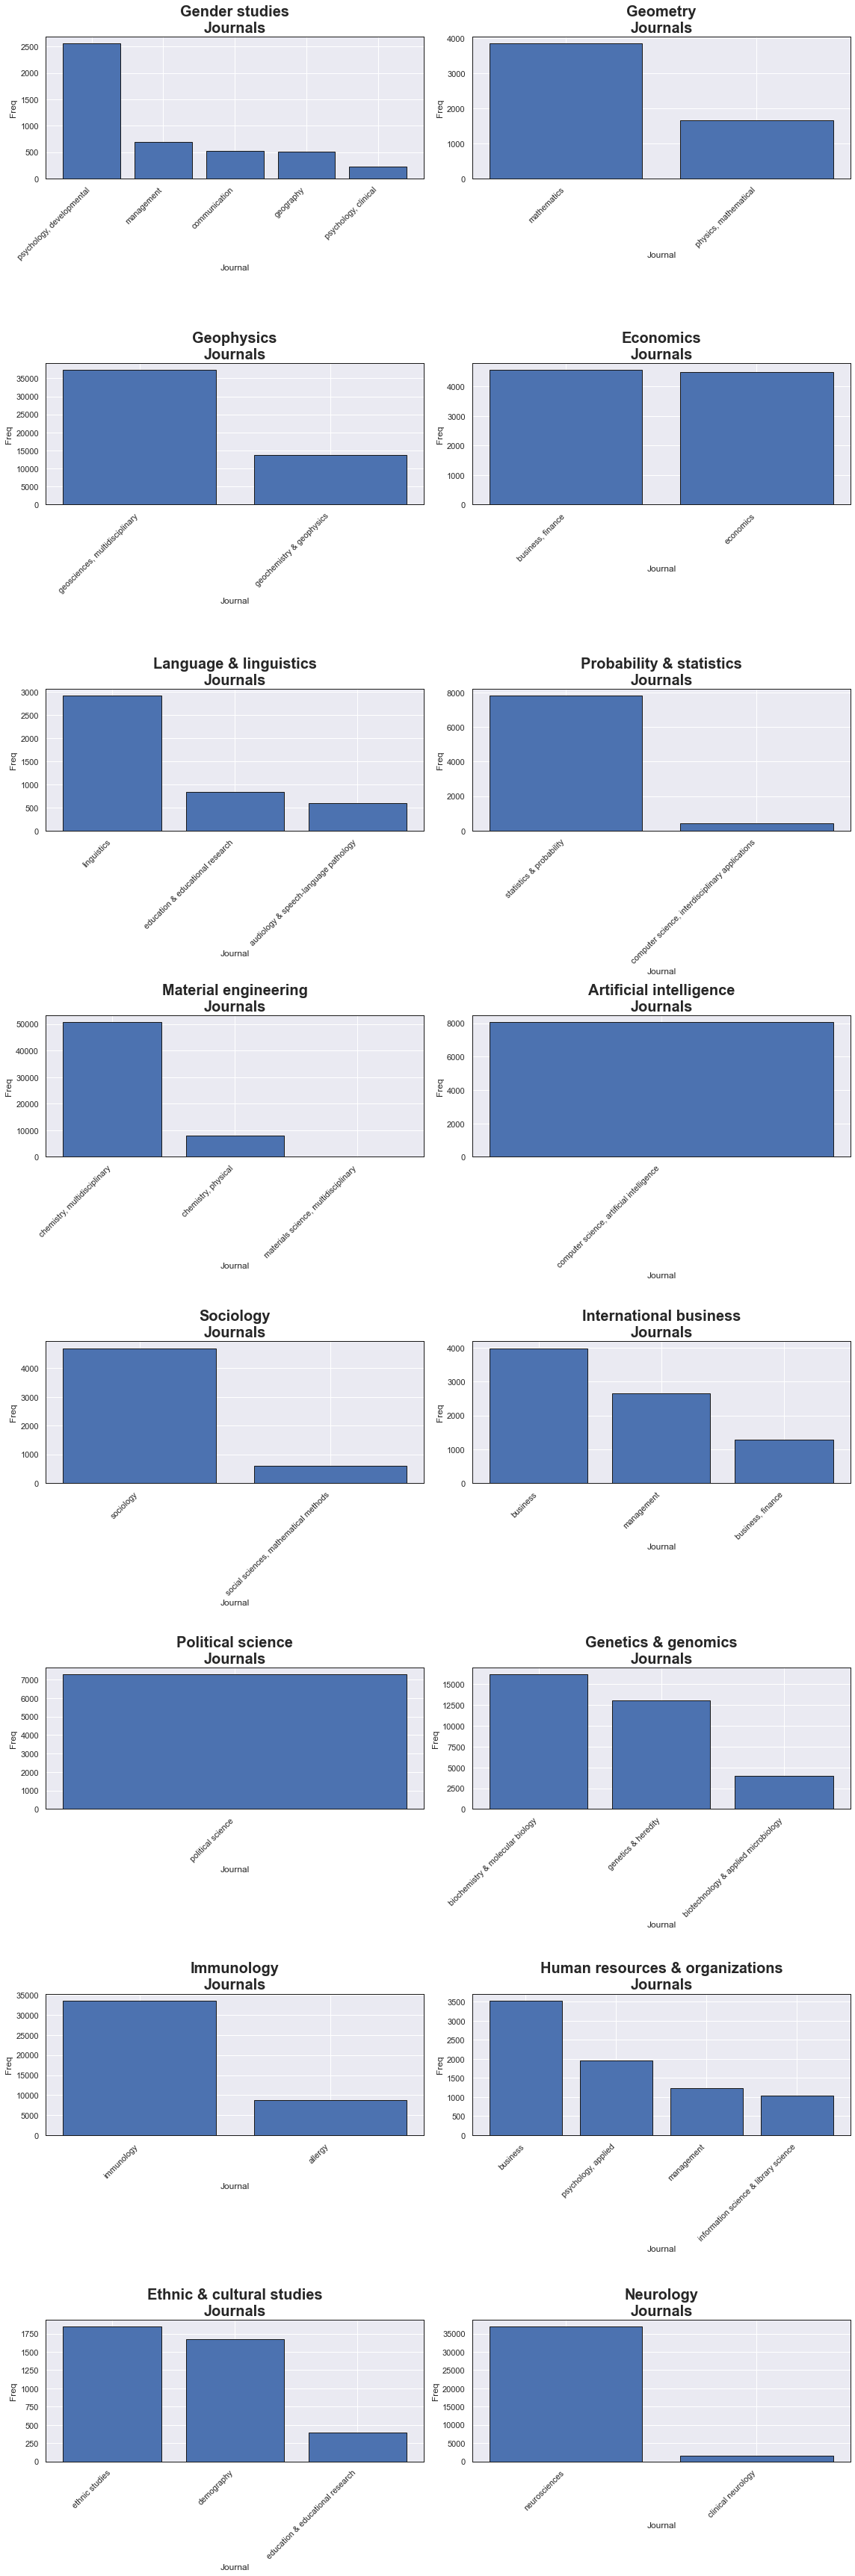

In [9]:
n_cols = 2
height = 6
width = 8
n_rows = np.ceil(len(corpora) / n_cols)

fig, axs = plt.subplots(int(n_rows), int(n_cols), figsize=(n_cols*width, n_rows*height))
for ax, (field_name, corpus) in zip(axs.flatten(), corpora.items()):

    journals, counts = corpus['Df'].select([pl.col('Category').arr.first()]).groupby('Category').agg([pl.count()]).sort(pl.col('count'), descending=True)
    journals = journals.to_list()[:5]
    counts = counts.to_list()[:5]

    ax.bar(journals, counts, edgecolor='k')
    ax.set_xlabel('Journal')
    ax.set_ylabel('Freq')

    ax.set_xticks(range(len(journals)), journals, rotation=45, ha='right')


    ax.set_title(f'{field_name.capitalize()}\nJournals', fontweight='semibold', fontsize=20)

    ax.spines['top'].set_color('k')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['right'].set_color('k')
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1)

fig.set_facecolor('w')
plt.tight_layout()
plt.savefig(f'{OBSIDIAN_IMG_PATH}/categories.png')
plt.show()

# Areas

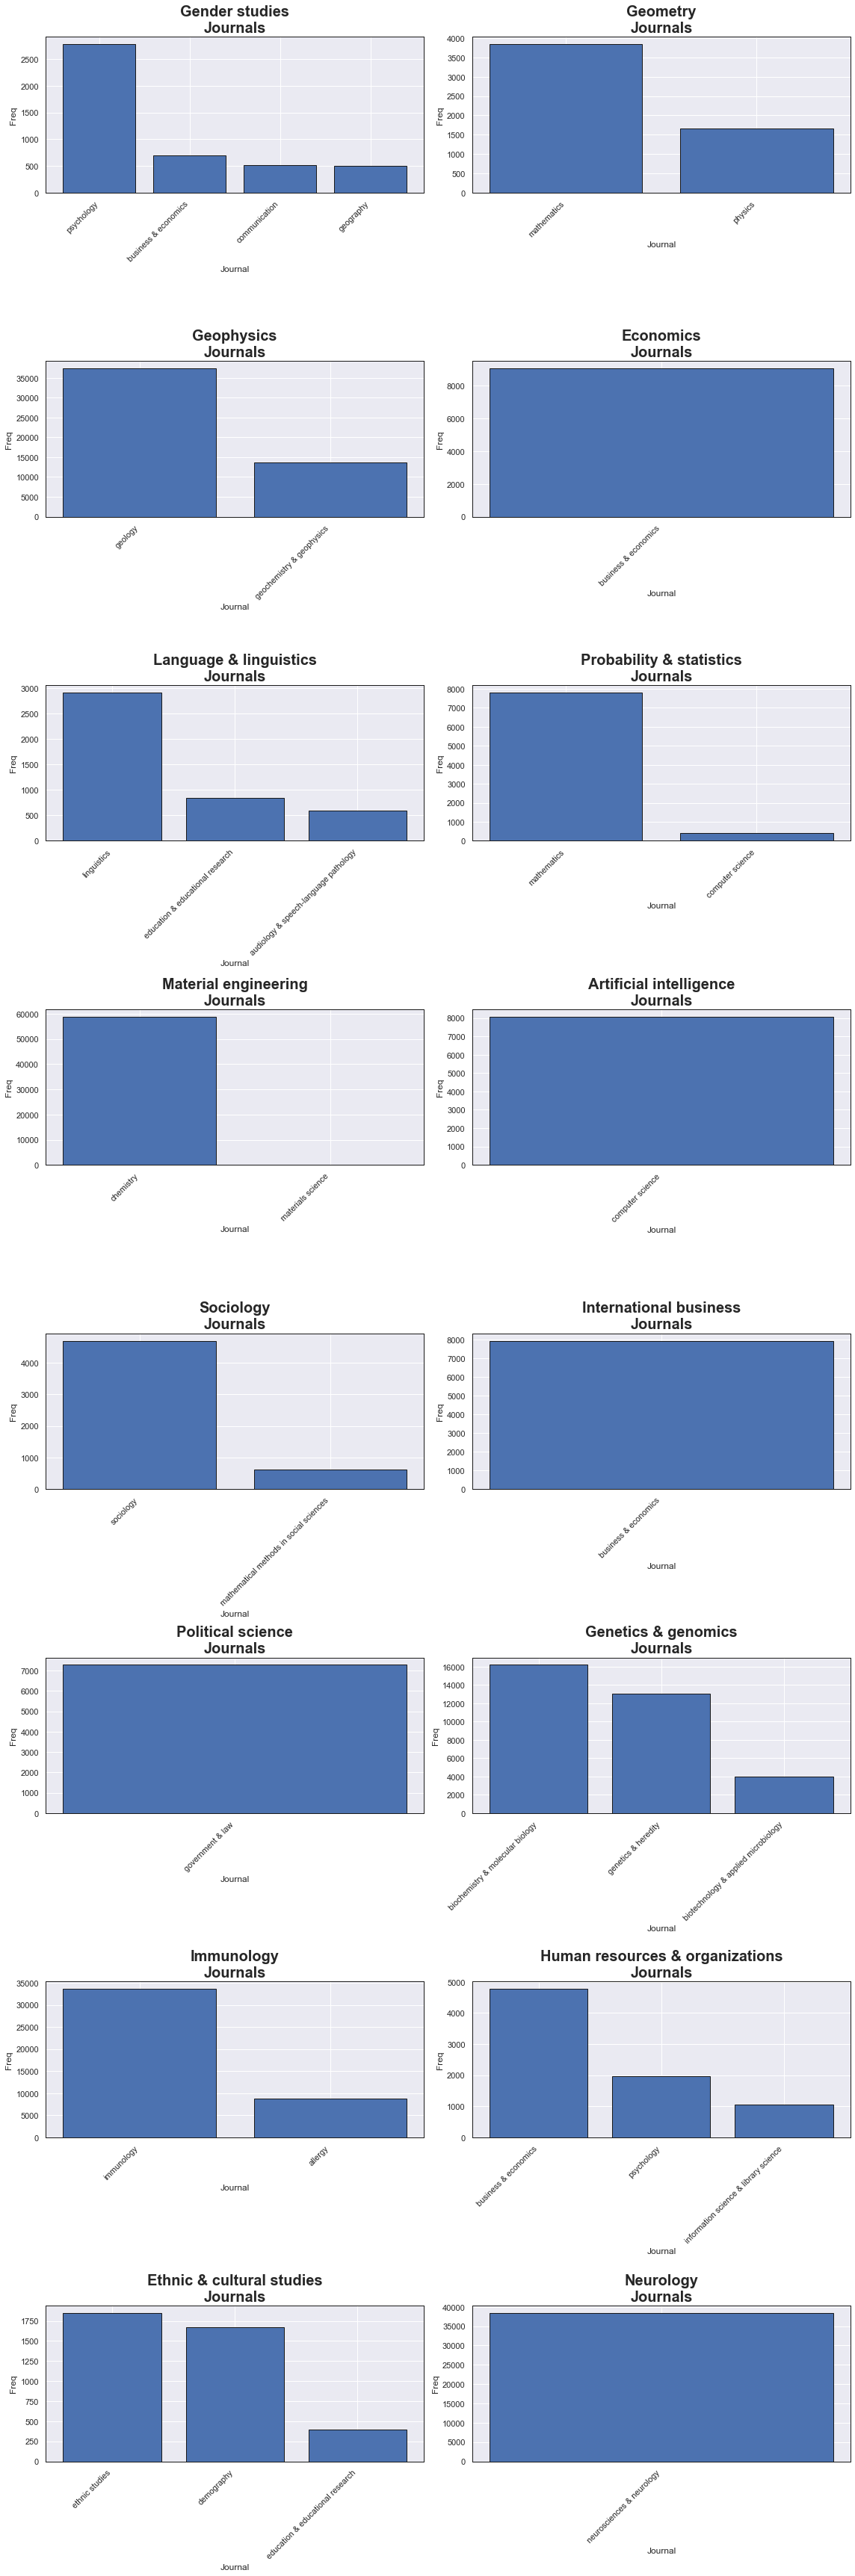

In [10]:
n_cols = 2
height = 6
width = 8
n_rows = np.ceil(len(corpora) / n_cols)

fig, axs = plt.subplots(int(n_rows), int(n_cols), figsize=(n_cols*width, n_rows*height))
for ax, (field_name, corpus) in zip(axs.flatten(), corpora.items()):

    journals, counts = corpus['Df'].select([pl.col('Areas').arr.first()]).groupby('Areas').agg([pl.count()]).sort(pl.col('count'), descending=True)
    journals = journals.to_list()[:5]
    counts = counts.to_list()[:5]

    ax.bar(journals, counts, edgecolor='k')
    ax.set_xlabel('Journal')
    ax.set_ylabel('Freq')

    ax.set_xticks(range(len(journals)), journals, rotation=45, ha='right')


    ax.set_title(f'{field_name.capitalize()}\nJournals', fontweight='semibold', fontsize=20)

    ax.spines['top'].set_color('k')
    ax.spines['top'].set_linewidth(1)
    ax.spines['bottom'].set_color('k')
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['right'].set_color('k')
    ax.spines['right'].set_linewidth(1)
    ax.spines['left'].set_color('k')
    ax.spines['left'].set_linewidth(1)

fig.set_facecolor('w')
plt.tight_layout()
plt.savefig(f'{OBSIDIAN_IMG_PATH}/areas.png')
plt.show()